**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import Boo-specific libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.utils import np_utils
from keras.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, normalize

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [3]:
# Import Yunzhou-specific libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

**Set Parameters**

In [4]:
N_STEPS = 10
SPLIT = 0.2
EPOCHS = 200

**Import and Clean Data**

In [6]:
# Import Data
raw_cases_df = pd.read_csv('Data/confirmed_diff.csv')
raw_deaths_df = pd.read_csv('Data/deaths_diff.csv')
raw_mobility_df = pd.read_csv('Data/Google_Mobility.csv')
# raw_whole_usa_cases_df = pd.read_csv('Data/us_confirmed_cases.csv')
# raw_whole_usa_deaths_df = pd.read_csv('Data/us_confirmed_deaths.csv')

In [7]:
# FOR STATES
# Clean Mobility Data
# mobility_df already contains only those counties and states for which
# complete data on all 6 mobility categories exist
mobility_df = raw_mobility_df.copy()
mobility_df = mobility_df.rename(columns={"retail_and_recreation_percent_change_from_baseline": "retail_and_recreation",
        "grocery_and_pharmacy_percent_change_from_baseline": "grocery_and_pharmacy",
        "parks_percent_change_from_baseline": "parks",
        "transit_stations_percent_change_from_baseline": "transit_stations",
        "workplaces_percent_change_from_baseline": "workplaces",
        "residential_percent_change_from_baseline": "residential"})
# Optional extreme shortening of names
if True:
    mobility_df = mobility_df.rename(columns={"retail_and_recreation": "rr",
            "grocery_and_pharmacy": "gp",
            "transit_stations": "ts",
            "workplaces": "wp",
            "residential": "res"})
# US is the country already, do not need that data
mobility_df.drop(columns=['country_region_code', 'country_region'], inplace=True)
mobility_df.rename(columns={'sub_region_1': 'state', 'sub_region_2': 'county'}, inplace=True)

# Extract all states only data, which have been marked with 'ZZZ' in the county name
state_mobility_df = (mobility_df[mobility_df['county'] == 'ZZZ']).copy()
state_mobility_df.drop(columns=['county'], inplace=True)

In [8]:
# FOR STATES
# Clean Cases Data
cases_df = raw_cases_df.copy()
cases_df.rename(columns={'Admin2': 'county', 'Province_State': 'state', 'Date': 'date', 'Value': 'cases'}, inplace=True)
# Since this is on the state level, county info is not needed
# 'region' and 'diff' are legacy columns that are not needed here
cases_df.drop(columns=['Country_Region', 'county', 'Lat', 'Long_', 'region', 'diff'], inplace=True)
# Sum up cases for each state
state_cases_df = cases_df.groupby(['state', 'date'], as_index=False).agg({'cases':'sum'})

In [9]:
# FOR STATES
# Merge Google Mobility and Cases Data
state_cases_mobility_df = state_cases_df.merge(state_mobility_df, how='inner', on=['state', 'date'])
# Sort to ensure proper order
state_cases_mobility_df['date'] = pd.to_datetime(state_cases_mobility_df['date'], format="%m/%d/%Y")
state_cases_mobility_df.sort_values(['state', 'date'], ascending=[True, True], inplace=True)

In [10]:
# List out all applicable states for later
state_names = ['South Carolina', 'Louisiana', 'Virginia', 'Idaho', 'Iowa',
               'Kentucky', 'Missouri', 'Oklahoma', 'Colorado', 'Illinois',
               'Indiana', 'Mississippi', 'Nebraska', 'North Dakota', 'Ohio',
               'Pennsylvania', 'Washington', 'Wisconsin', 'Vermont', 'Minnesota',
               'Florida', 'North Carolina', 'California', 'New York', 'Wyoming',
               'Michigan', 'Alaska', 'Maryland', 'Kansas', 'Tennessee', 'Texas',
               'Maine', 'Arizona', 'Georgia', 'Arkansas', 'New Jersey',
               'South Dakota', 'Alabama', 'Oregon', 'West Virginia',
               'Massachusetts', 'Utah', 'Montana', 'New Hampshire', 'New Mexico',
               'Rhode Island', 'Nevada', 'District of Columbia', 'Connecticut',
               'Hawaii']
# total of 50 statewide data (49 states + Washington D.C.)
# Missing Delaware
state_names_no_mobility = state_names.copy()
state_names_no_mobility.append('Delaware')


As is, "state_cases_mobility_df" contains confirmed cases data for each state at each point in time, with mobility data.

"state_cases_df" only contains confirmed cases data.

**Transform Data**

*Note that these models all assume,
the underlying trend of cases for each state is the same,
and there are no state-by-state variations in how the disease spreads,
which is likely unrealistic*

In [11]:
# Normalize Data
# Following Boo
# scaler = MinMaxScaler(feature_range=(0,1))
# state_cases_mobility_normalized_df = scaler.fit_transform(state_cases_mobility_df)

In [12]:
# Remember to Split Data into Training and Validation Sets

In [13]:
# Organize Data for LSTM
# Objective is to predict cases for current day given previous N_STEPS days
# However, having multiple states, each as their own individual time series,
# complicates this.
# input should be of shape (n_steps, n_features) with multiple samples

# Modified from Boo's code
def get_LSTM_states_dataset(dataset, n_steps=1):
    dataset = dataset.copy()
    dataset.drop(columns=['date'], inplace=True)
    #print(dataset.shape)
    dataset_by_states = []
    # Normalize data while you are at it
    scaler = MinMaxScaler(feature_range=(0,1))
    for state in dataset['state'].unique():
        state_values = dataset[dataset['state'] == state].drop(columns='state').values
        state_values = scaler.fit_transform(state_values)
        dataset_by_states.append(state_values)
    X, y = [], []
    for state_dataset in dataset_by_states:
        for i in range(len(state_dataset) - n_steps - 1):
            a = state_dataset[i:(i+n_steps)]
            X.append(a)
            y.append(state_dataset[i + n_steps][0])
    X, y = np.array(X), np.array(y)
    return X, y

X_LSTM, y_LSTM = get_LSTM_states_dataset(state_cases_mobility_df, n_steps=N_STEPS)
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(X_LSTM, y_LSTM, test_size=SPLIT, shuffle=False)

In [14]:
# Organize Data for CNN/Regular NN
# Objective is to predict cases for current day given previous N_STEPS days.
# We must add the value of the columns from previous
# days as extra features per observation
def get_CNN_states_dataset(dataset, n_steps=1):
    dataset = dataset.copy()
    dataset.drop(columns=['date'], inplace=True)
    #print(dataset.shape)
    dataset_by_states = []
    # Normalize data while you are at it
    scaler = MinMaxScaler(feature_range=(0,1))
    for state in dataset['state'].unique():
        state_values = dataset[dataset['state'] == state].drop(columns='state').values
        state_values = scaler.fit_transform(state_values)
        dataset_by_states.append(state_values)
    X, y = [], []
    for state_dataset in dataset_by_states:
        for i in range(len(state_dataset) - n_steps - 1):
            a = state_dataset[i:(i+n_steps)]
            X.append(a)
            y.append(state_dataset[i + n_steps][0])
    X, y = np.array(X), np.array(y)
    return X, y

X_CNN, y_CNN = get_CNN_states_dataset(state_cases_mobility_df, n_steps=N_STEPS)
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(X_CNN, y_CNN, test_size=SPLIT, shuffle=False)

In [15]:
# Organize Data for Yunzhou's NN

def get_YNN_states_dataset(dataset, n_steps=1):
    dataset = dataset.copy()
    dataset.drop(columns=['date'], inplace=True)
    #print(dataset.shape)
    dataset_by_states = []
    # Normalize data while you are at it
    scaler = MinMaxScaler(feature_range=(0,1))
    for state in dataset['state'].unique():
        state_values = dataset[dataset['state'] == state].drop(columns='state').values
        state_values = scaler.fit_transform(state_values)
        dataset_by_states.append(state_values)
    X, y = [], []
    for state_dataset in dataset_by_states:
        for i in range(len(state_dataset) - n_steps - 1):
            a = state_dataset[i:(i+n_steps)]
            # Flatten a, a list of lists, into a single row of features
            flat_a = []
            for sublist in a:
                for item in sublist:
                    flat_a.append(item)
            X.append(flat_a)
            y.append(state_dataset[i + n_steps][0])
    X, y = np.array(X), np.array(y)
    return X, y

X_YNN, y_YNN = get_YNN_states_dataset(state_cases_mobility_df, n_steps=N_STEPS)
X_train_YNN, X_test_YNN, y_train_YNN, y_test_YNN = train_test_split(X_YNN, y_YNN, test_size=SPLIT, shuffle=False)

**LSTM Model with Mobility Data**

In [17]:
# Set up LSTM, Boo's model
def get_lstm(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(128, input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    adam = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer = 'adam', loss='mse', metrics=['mae', 'mse'])
    return model

n_lstm_features = X_train_LSTM.shape[2]
lstm = get_lstm(N_STEPS, n_lstm_features)

In [18]:
# Fit LSTM
lstmhistory = lstm.fit(X_train_LSTM, y_train_LSTM,
                       epochs=EPOCHS,
                       validation_data=(X_test_LSTM, y_test_LSTM),
                       verbose=1,
                       shuffle=False)


Train on 2440 samples, validate on 610 samples
Epoch 1/200
2440/2440 [==============================] - 1s 407us/step - loss: 0.0197 - mae: 0.0881 - mse: 0.0197 - val_loss: 0.0029 - val_mae: 0.0367 - val_mse: 0.0029
Epoch 2/200
2440/2440 [==============================] - 1s 235us/step - loss: 0.0019 - mae: 0.0312 - mse: 0.0019 - val_loss: 0.0018 - val_mae: 0.0265 - val_mse: 0.0018
Epoch 3/200
2440/2440 [==============================] - 1s 227us/step - loss: 0.0015 - mae: 0.0263 - mse: 0.0015 - val_loss: 0.0015 - val_mae: 0.0250 - val_mse: 0.0015
Epoch 4/200
2440/2440 [==============================] - 1s 234us/step - loss: 0.0012 - mae: 0.0237 - mse: 0.0012 - val_loss: 0.0012 - val_mae: 0.0227 - val_mse: 0.0012
Epoch 5/200
2440/2440 [==============================] - 1s 227us/step - loss: 0.0011 - mae: 0.0228 - mse: 0.0011 - val_loss: 0.0011 - val_mae: 0.0213 - val_mse: 0.0011
Epoch 6/200
2440/2440 [==============================] - 1s 237us/step - loss: 0.0010 - mae: 0.0224 - mse: 

2440/2440 [==============================] - 0s 185us/step - loss: 2.2037e-04 - mae: 0.0099 - mse: 2.2037e-04 - val_loss: 2.6592e-04 - val_mae: 0.0100 - val_mse: 2.6592e-04
Epoch 45/200
2440/2440 [==============================] - 0s 183us/step - loss: 2.1673e-04 - mae: 0.0098 - mse: 2.1673e-04 - val_loss: 2.6301e-04 - val_mae: 0.0098 - val_mse: 2.6301e-04
Epoch 46/200
2440/2440 [==============================] - 0s 187us/step - loss: 2.1337e-04 - mae: 0.0098 - mse: 2.1337e-04 - val_loss: 2.6052e-04 - val_mae: 0.0097 - val_mse: 2.6052e-04
Epoch 47/200
2440/2440 [==============================] - 0s 189us/step - loss: 2.1025e-04 - mae: 0.0097 - mse: 2.1025e-04 - val_loss: 2.5837e-04 - val_mae: 0.0095 - val_mse: 2.5837e-04
Epoch 48/200
2440/2440 [==============================] - 0s 187us/step - loss: 2.0733e-04 - mae: 0.0096 - mse: 2.0733e-04 - val_loss: 2.5651e-04 - val_mae: 0.0094 - val_mse: 2.5651e-04
Epoch 49/200
2440/2440 [==============================] - 0s 187us/step - loss: 2.0

2440/2440 [==============================] - 1s 219us/step - loss: 1.6327e-04 - mae: 0.0085 - mse: 1.6327e-04 - val_loss: 2.4226e-04 - val_mae: 0.0098 - val_mse: 2.4226e-04
Epoch 89/200
2440/2440 [==============================] - 1s 209us/step - loss: 1.6264e-04 - mae: 0.0084 - mse: 1.6264e-04 - val_loss: 2.3916e-04 - val_mae: 0.0097 - val_mse: 2.3916e-04
Epoch 90/200
2440/2440 [==============================] - 1s 215us/step - loss: 1.6216e-04 - mae: 0.0084 - mse: 1.6216e-04 - val_loss: 2.3578e-04 - val_mae: 0.0095 - val_mse: 2.3578e-04
Epoch 91/200
2440/2440 [==============================] - 1s 208us/step - loss: 1.6185e-04 - mae: 0.0084 - mse: 1.6185e-04 - val_loss: 2.3255e-04 - val_mae: 0.0093 - val_mse: 2.3255e-04
Epoch 92/200
2440/2440 [==============================] - 1s 212us/step - loss: 1.6169e-04 - mae: 0.0084 - mse: 1.6169e-04 - val_loss: 2.2965e-04 - val_mae: 0.0091 - val_mse: 2.2965e-04
Epoch 93/200
2440/2440 [==============================] - 1s 217us/step - loss: 1.6

Epoch 132/200
2440/2440 [==============================] - 1s 207us/step - loss: 1.4811e-04 - mae: 0.0078 - mse: 1.4811e-04 - val_loss: 2.1360e-04 - val_mae: 0.0081 - val_mse: 2.1360e-04
Epoch 133/200
2440/2440 [==============================] - 1s 214us/step - loss: 1.4799e-04 - mae: 0.0078 - mse: 1.4799e-04 - val_loss: 2.1336e-04 - val_mae: 0.0081 - val_mse: 2.1336e-04
Epoch 134/200
2440/2440 [==============================] - 1s 213us/step - loss: 1.4791e-04 - mae: 0.0078 - mse: 1.4791e-04 - val_loss: 2.1304e-04 - val_mae: 0.0081 - val_mse: 2.1304e-04
Epoch 135/200
2440/2440 [==============================] - 1s 213us/step - loss: 1.4788e-04 - mae: 0.0078 - mse: 1.4788e-04 - val_loss: 2.1262e-04 - val_mae: 0.0081 - val_mse: 2.1262e-04
Epoch 136/200
2440/2440 [==============================] - 1s 221us/step - loss: 1.4792e-04 - mae: 0.0078 - mse: 1.4792e-04 - val_loss: 2.1206e-04 - val_mae: 0.0080 - val_mse: 2.1206e-04
Epoch 137/200
2440/2440 [==============================] - 1s 217

Epoch 176/200
2440/2440 [==============================] - 1s 214us/step - loss: 1.4643e-04 - mae: 0.0079 - mse: 1.4643e-04 - val_loss: 2.0748e-04 - val_mae: 0.0078 - val_mse: 2.0748e-04
Epoch 177/200
2440/2440 [==============================] - 1s 211us/step - loss: 1.3587e-04 - mae: 0.0073 - mse: 1.3587e-04 - val_loss: 2.0584e-04 - val_mae: 0.0076 - val_mse: 2.0584e-04
Epoch 178/200
2440/2440 [==============================] - 1s 210us/step - loss: 1.3447e-04 - mae: 0.0073 - mse: 1.3447e-04 - val_loss: 2.0783e-04 - val_mae: 0.0077 - val_mse: 2.0783e-04
Epoch 179/200
2440/2440 [==============================] - 1s 212us/step - loss: 1.3484e-04 - mae: 0.0073 - mse: 1.3484e-04 - val_loss: 2.0812e-04 - val_mae: 0.0077 - val_mse: 2.0812e-04
Epoch 180/200
2440/2440 [==============================] - 1s 210us/step - loss: 1.3516e-04 - mae: 0.0073 - mse: 1.3516e-04 - val_loss: 2.0817e-04 - val_mae: 0.0076 - val_mse: 2.0817e-04
Epoch 181/200
2440/2440 [==============================] - 1s 208

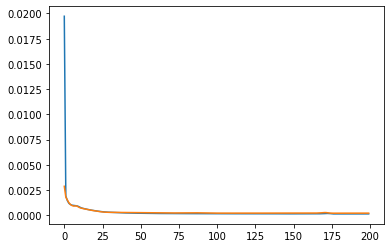

In [19]:
# Graph LSTM Error, mae and mse
plt.plot(lstmhistory.history['loss'])
plt.plot(lstmhistory.history['val_loss'])


**LSTM Model WITHOUT Mobility Data**

In [20]:
# Get data
X_LSTM_nomob, y_LSTM_nomob = get_LSTM_states_dataset(state_cases_df, n_steps=N_STEPS)
X_train_LSTM_nomob, X_test_LSTM_nomob, y_train_LSTM_nomob, y_test_LSTM_nomob = train_test_split(X_LSTM_nomob, y_LSTM_nomob, test_size=SPLIT, shuffle=False)

# Set up model
n_lstm_features = X_train_LSTM_nomob.shape[2]
lstm_nomob = get_lstm(N_STEPS, n_lstm_features)

# Fit LSTM
lstm_nomob_history = lstm_nomob.fit(X_train_LSTM_nomob, y_train_LSTM_nomob,
                                     epochs=EPOCHS,
                                     validation_data=(X_test_LSTM_nomob, y_test_LSTM_nomob),
                                     verbose=1,
                                     shuffle=False)

Train on 4222 samples, validate on 1056 samples
Epoch 1/200
4222/4222 [==============================] - 1s 306us/step - loss: 0.0325 - mae: 0.1143 - mse: 0.0325 - val_loss: 0.0241 - val_mae: 0.0972 - val_mse: 0.0241
Epoch 2/200
4222/4222 [==============================] - 1s 222us/step - loss: 0.0229 - mae: 0.0835 - mse: 0.0229 - val_loss: 0.0204 - val_mae: 0.0805 - val_mse: 0.0204
Epoch 3/200
4222/4222 [==============================] - 1s 226us/step - loss: 0.0200 - mae: 0.0719 - mse: 0.0200 - val_loss: 0.0185 - val_mae: 0.0724 - val_mse: 0.0185
Epoch 4/200
4222/4222 [==============================] - 1s 252us/step - loss: 0.0186 - mae: 0.0671 - mse: 0.0186 - val_loss: 0.0172 - val_mae: 0.0690 - val_mse: 0.0172
Epoch 5/200
4222/4222 [==============================] - 1s 243us/step - loss: 0.0174 - mae: 0.0649 - mse: 0.0174 - val_loss: 0.0158 - val_mae: 0.0702 - val_mse: 0.0158
Epoch 6/200
4222/4222 [==============================] - 1s 249us/step - loss: 0.0162 - mae: 0.0629 - mse: 

Epoch 49/200
4222/4222 [==============================] - 1s 208us/step - loss: 0.0056 - mae: 0.0348 - mse: 0.0056 - val_loss: 0.0075 - val_mae: 0.0392 - val_mse: 0.0075
Epoch 50/200
4222/4222 [==============================] - 1s 207us/step - loss: 0.0055 - mae: 0.0343 - mse: 0.0055 - val_loss: 0.0075 - val_mae: 0.0393 - val_mse: 0.0075
Epoch 51/200
4222/4222 [==============================] - 1s 207us/step - loss: 0.0052 - mae: 0.0337 - mse: 0.0052 - val_loss: 0.0074 - val_mae: 0.0386 - val_mse: 0.0074
Epoch 52/200
4222/4222 [==============================] - 1s 208us/step - loss: 0.0050 - mae: 0.0331 - mse: 0.0050 - val_loss: 0.0074 - val_mae: 0.0378 - val_mse: 0.0074
Epoch 53/200
4222/4222 [==============================] - 1s 210us/step - loss: 0.0048 - mae: 0.0326 - mse: 0.0048 - val_loss: 0.0074 - val_mae: 0.0389 - val_mse: 0.0074
Epoch 54/200
4222/4222 [==============================] - 1s 208us/step - loss: 0.0046 - mae: 0.0321 - mse: 0.0046 - val_loss: 0.0074 - val_mae: 0.040

4222/4222 [==============================] - 1s 215us/step - loss: 0.0019 - mae: 0.0186 - mse: 0.0019 - val_loss: 0.0027 - val_mae: 0.0226 - val_mse: 0.0027
Epoch 98/200
4222/4222 [==============================] - 1s 213us/step - loss: 0.0019 - mae: 0.0184 - mse: 0.0019 - val_loss: 0.0027 - val_mae: 0.0224 - val_mse: 0.0027
Epoch 99/200
4222/4222 [==============================] - 1s 209us/step - loss: 0.0018 - mae: 0.0183 - mse: 0.0018 - val_loss: 0.0027 - val_mae: 0.0222 - val_mse: 0.0027
Epoch 100/200
4222/4222 [==============================] - 1s 209us/step - loss: 0.0018 - mae: 0.0182 - mse: 0.0018 - val_loss: 0.0027 - val_mae: 0.0220 - val_mse: 0.0027
Epoch 101/200
4222/4222 [==============================] - 1s 212us/step - loss: 0.0018 - mae: 0.0182 - mse: 0.0018 - val_loss: 0.0027 - val_mae: 0.0219 - val_mse: 0.0027
Epoch 102/200
4222/4222 [==============================] - 1s 212us/step - loss: 0.0018 - mae: 0.0181 - mse: 0.0018 - val_loss: 0.0027 - val_mae: 0.0220 - val_ms

4222/4222 [==============================] - 1s 214us/step - loss: 0.0017 - mae: 0.0172 - mse: 0.0017 - val_loss: 0.0029 - val_mae: 0.0226 - val_mse: 0.0029
Epoch 146/200
4222/4222 [==============================] - 1s 213us/step - loss: 0.0012 - mae: 0.0150 - mse: 0.0012 - val_loss: 0.0027 - val_mae: 0.0216 - val_mse: 0.0027
Epoch 147/200
4222/4222 [==============================] - 1s 210us/step - loss: 0.0019 - mae: 0.0176 - mse: 0.0019 - val_loss: 0.0028 - val_mae: 0.0218 - val_mse: 0.0028
Epoch 148/200
4222/4222 [==============================] - 1s 214us/step - loss: 0.0012 - mae: 0.0145 - mse: 0.0012 - val_loss: 0.0026 - val_mae: 0.0212 - val_mse: 0.0026
Epoch 149/200
4222/4222 [==============================] - 1s 214us/step - loss: 0.0018 - mae: 0.0179 - mse: 0.0018 - val_loss: 0.0026 - val_mae: 0.0208 - val_mse: 0.0026
Epoch 150/200
4222/4222 [==============================] - 1s 208us/step - loss: 0.0013 - mae: 0.0152 - mse: 0.0013 - val_loss: 0.0025 - val_mae: 0.0212 - val_

Epoch 193/200
4222/4222 [==============================] - 1s 213us/step - loss: 0.0013 - mae: 0.0153 - mse: 0.0013 - val_loss: 0.0020 - val_mae: 0.0184 - val_mse: 0.0020
Epoch 194/200
4222/4222 [==============================] - 1s 213us/step - loss: 0.0011 - mae: 0.0144 - mse: 0.0011 - val_loss: 0.0020 - val_mae: 0.0199 - val_mse: 0.0020
Epoch 195/200
4222/4222 [==============================] - 1s 212us/step - loss: 0.0019 - mae: 0.0179 - mse: 0.0019 - val_loss: 0.0020 - val_mae: 0.0186 - val_mse: 0.0020
Epoch 196/200
4222/4222 [==============================] - 1s 212us/step - loss: 0.0013 - mae: 0.0148 - mse: 0.0013 - val_loss: 0.0021 - val_mae: 0.0185 - val_mse: 0.0021
Epoch 197/200
4222/4222 [==============================] - 1s 217us/step - loss: 0.0016 - mae: 0.0158 - mse: 0.0016 - val_loss: 0.0022 - val_mae: 0.0188 - val_mse: 0.0022
Epoch 198/200
4222/4222 [==============================] - 1s 217us/step - loss: 0.0011 - mae: 0.0140 - mse: 0.0011 - val_loss: 0.0020 - val_mae:

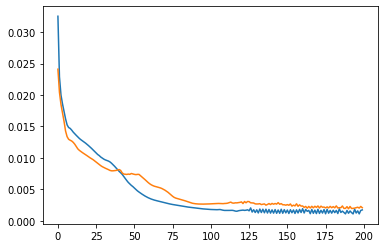

In [21]:
# Graph LSTM Error, mae and mse
plt.plot(lstm_nomob_history.history['loss'])
plt.plot(lstm_nomob_history.history['val_loss'])


**STACKED LSTM Model with Mobility Data**

In [22]:
# Set up Stacked LSTM, Boo's model
def get_stacked_lstm(n_steps, n_features):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(128, input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer = 'adam', loss='mse', metrics=['mae', 'mse'])
    return model

n_lstm_features = X_train_LSTM.shape[2]
slstm = get_stacked_lstm(N_STEPS, n_lstm_features)

In [23]:
# Use same data from earlier to fit the model
slstmhistory = slstm.fit(X_train_LSTM, y_train_LSTM,
                       epochs=EPOCHS,
                       validation_data=(X_test_LSTM, y_test_LSTM),
                       verbose=1,
                       shuffle=False)


Train on 2440 samples, validate on 610 samples
Epoch 1/200
2440/2440 [==============================] - 2s 748us/step - loss: 0.0191 - mae: 0.0854 - mse: 0.0191 - val_loss: 0.0025 - val_mae: 0.0332 - val_mse: 0.0025
Epoch 2/200
2440/2440 [==============================] - 1s 442us/step - loss: 0.0026 - mae: 0.0369 - mse: 0.0026 - val_loss: 0.0021 - val_mae: 0.0330 - val_mse: 0.0021
Epoch 3/200
2440/2440 [==============================] - 1s 452us/step - loss: 0.0024 - mae: 0.0356 - mse: 0.0024 - val_loss: 0.0018 - val_mae: 0.0324 - val_mse: 0.0018
Epoch 4/200
2440/2440 [==============================] - 1s 456us/step - loss: 0.0019 - mae: 0.0320 - mse: 0.0019 - val_loss: 0.0016 - val_mae: 0.0314 - val_mse: 0.0016
Epoch 5/200
2440/2440 [==============================] - 1s 526us/step - loss: 0.0016 - mae: 0.0298 - mse: 0.0016 - val_loss: 0.0013 - val_mae: 0.0260 - val_mse: 0.0013
Epoch 6/200
2440/2440 [==============================] - 1s 488us/step - loss: 0.0015 - mae: 0.0287 - mse: 0

Epoch 46/200
2440/2440 [==============================] - 1s 431us/step - loss: 2.3007e-04 - mae: 0.0105 - mse: 2.3007e-04 - val_loss: 2.4178e-04 - val_mae: 0.0086 - val_mse: 2.4178e-04
Epoch 47/200
2440/2440 [==============================] - 1s 435us/step - loss: 2.2658e-04 - mae: 0.0104 - mse: 2.2658e-04 - val_loss: 2.3985e-04 - val_mae: 0.0085 - val_mse: 2.3985e-04
Epoch 48/200
2440/2440 [==============================] - 1s 433us/step - loss: 2.2368e-04 - mae: 0.0104 - mse: 2.2368e-04 - val_loss: 2.3821e-04 - val_mae: 0.0085 - val_mse: 2.3821e-04
Epoch 49/200
2440/2440 [==============================] - 1s 436us/step - loss: 2.2132e-04 - mae: 0.0103 - mse: 2.2132e-04 - val_loss: 2.3681e-04 - val_mae: 0.0085 - val_mse: 2.3681e-04
Epoch 50/200
2440/2440 [==============================] - 1s 431us/step - loss: 2.1941e-04 - mae: 0.0103 - mse: 2.1941e-04 - val_loss: 2.3561e-04 - val_mae: 0.0084 - val_mse: 2.3561e-04
Epoch 51/200
2440/2440 [==============================] - 1s 430us/ste

2440/2440 [==============================] - 1s 435us/step - loss: 1.9763e-04 - mae: 0.0096 - mse: 1.9763e-04 - val_loss: 2.4546e-04 - val_mae: 0.0103 - val_mse: 2.4546e-04
Epoch 91/200
2440/2440 [==============================] - 1s 427us/step - loss: 1.9866e-04 - mae: 0.0096 - mse: 1.9866e-04 - val_loss: 2.4886e-04 - val_mae: 0.0104 - val_mse: 2.4886e-04
Epoch 92/200
2440/2440 [==============================] - 1s 436us/step - loss: 2.0008e-04 - mae: 0.0096 - mse: 2.0008e-04 - val_loss: 2.5308e-04 - val_mae: 0.0107 - val_mse: 2.5308e-04
Epoch 93/200
2440/2440 [==============================] - 1s 430us/step - loss: 2.0202e-04 - mae: 0.0097 - mse: 2.0202e-04 - val_loss: 2.5827e-04 - val_mae: 0.0109 - val_mse: 2.5827e-04
Epoch 94/200
2440/2440 [==============================] - 1s 428us/step - loss: 2.0469e-04 - mae: 0.0098 - mse: 2.0469e-04 - val_loss: 2.6453e-04 - val_mae: 0.0112 - val_mse: 2.6453e-04
Epoch 95/200
2440/2440 [==============================] - 1s 507us/step - loss: 2.0

Epoch 134/200
2440/2440 [==============================] - 1s 427us/step - loss: 1.7364e-04 - mae: 0.0088 - mse: 1.7364e-04 - val_loss: 2.0959e-04 - val_mae: 0.0075 - val_mse: 2.0959e-04
Epoch 135/200
2440/2440 [==============================] - 1s 435us/step - loss: 1.7321e-04 - mae: 0.0088 - mse: 1.7321e-04 - val_loss: 2.0994e-04 - val_mae: 0.0076 - val_mse: 2.0994e-04
Epoch 136/200
2440/2440 [==============================] - 1s 424us/step - loss: 1.7284e-04 - mae: 0.0087 - mse: 1.7284e-04 - val_loss: 2.1029e-04 - val_mae: 0.0076 - val_mse: 2.1029e-04
Epoch 137/200
2440/2440 [==============================] - 1s 428us/step - loss: 1.7253e-04 - mae: 0.0087 - mse: 1.7253e-04 - val_loss: 2.1059e-04 - val_mae: 0.0076 - val_mse: 2.1059e-04
Epoch 138/200
2440/2440 [==============================] - 1s 417us/step - loss: 1.7225e-04 - mae: 0.0087 - mse: 1.7225e-04 - val_loss: 2.1083e-04 - val_mae: 0.0076 - val_mse: 2.1083e-04
Epoch 139/200
2440/2440 [==============================] - 1s 425

Epoch 178/200
2440/2440 [==============================] - 1s 468us/step - loss: 1.5968e-04 - mae: 0.0081 - mse: 1.5968e-04 - val_loss: 2.1353e-04 - val_mae: 0.0080 - val_mse: 2.1353e-04
Epoch 179/200
2440/2440 [==============================] - 1s 472us/step - loss: 1.5910e-04 - mae: 0.0081 - mse: 1.5910e-04 - val_loss: 2.1323e-04 - val_mae: 0.0080 - val_mse: 2.1323e-04
Epoch 180/200
2440/2440 [==============================] - 1s 487us/step - loss: 1.5874e-04 - mae: 0.0081 - mse: 1.5874e-04 - val_loss: 2.1282e-04 - val_mae: 0.0080 - val_mse: 2.1282e-04
Epoch 181/200
2440/2440 [==============================] - 1s 499us/step - loss: 1.5853e-04 - mae: 0.0081 - mse: 1.5853e-04 - val_loss: 2.1241e-04 - val_mae: 0.0080 - val_mse: 2.1241e-04
Epoch 182/200
2440/2440 [==============================] - 1s 493us/step - loss: 1.5819e-04 - mae: 0.0081 - mse: 1.5819e-04 - val_loss: 2.1218e-04 - val_mae: 0.0079 - val_mse: 2.1218e-04
Epoch 183/200
2440/2440 [==============================] - 1s 498

**Stacked LSTM Model WITHOUT Mobility Data**

In [24]:
# Reuse No-mobility Data
# X_LSTM_nomob, y_LSTM_nomob = get_LSTM_states_dataset(state_cases_df, n_steps=N_STEPS)
# X_train_LSTM_nomob, X_test_LSTM_nomob, y_train_LSTM_nomob, y_test_LSTM_nomob = train_test_split(X_LSTM_nomob, y_LSTM_nomob, test_size=SPLIT, shuffle=False)

# Set up model
n_lstm_features = X_train_LSTM_nomob.shape[2]
slstm_nomob = get_lstm(N_STEPS, n_lstm_features)

# Fit LSTM
slstm_nomob_history = slstm_nomob.fit(X_train_LSTM_nomob, y_train_LSTM_nomob,
                                     epochs=EPOCHS,
                                     validation_data=(X_test_LSTM_nomob, y_test_LSTM_nomob),
                                     verbose=1,
                                     shuffle=False)

Train on 4222 samples, validate on 1056 samples
Epoch 1/200
4222/4222 [==============================] - 2s 365us/step - loss: 0.0343 - mae: 0.1183 - mse: 0.0343 - val_loss: 0.0245 - val_mae: 0.0988 - val_mse: 0.0245
Epoch 2/200
4222/4222 [==============================] - 1s 227us/step - loss: 0.0231 - mae: 0.0850 - mse: 0.0231 - val_loss: 0.0206 - val_mae: 0.0815 - val_mse: 0.0206
Epoch 3/200
4222/4222 [==============================] - 1s 240us/step - loss: 0.0199 - mae: 0.0723 - mse: 0.0199 - val_loss: 0.0184 - val_mae: 0.0725 - val_mse: 0.0184
Epoch 4/200
4222/4222 [==============================] - 1s 228us/step - loss: 0.0183 - mae: 0.0672 - mse: 0.0183 - val_loss: 0.0168 - val_mae: 0.0710 - val_mse: 0.0168
Epoch 5/200
4222/4222 [==============================] - 1s 222us/step - loss: 0.0167 - mae: 0.0640 - mse: 0.0167 - val_loss: 0.0149 - val_mae: 0.0689 - val_mse: 0.0149
Epoch 6/200
4222/4222 [==============================] - 1s 226us/step - loss: 0.0157 - mae: 0.0615 - mse: 

Epoch 49/200
4222/4222 [==============================] - 1s 188us/step - loss: 0.0042 - mae: 0.0314 - mse: 0.0042 - val_loss: 0.0040 - val_mae: 0.0314 - val_mse: 0.0040
Epoch 50/200
4222/4222 [==============================] - 1s 206us/step - loss: 0.0041 - mae: 0.0305 - mse: 0.0041 - val_loss: 0.0041 - val_mae: 0.0306 - val_mse: 0.0041
Epoch 51/200
4222/4222 [==============================] - 1s 232us/step - loss: 0.0039 - mae: 0.0299 - mse: 0.0039 - val_loss: 0.0042 - val_mae: 0.0316 - val_mse: 0.0042
Epoch 52/200
4222/4222 [==============================] - 1s 209us/step - loss: 0.0038 - mae: 0.0296 - mse: 0.0038 - val_loss: 0.0042 - val_mae: 0.0324 - val_mse: 0.0042
Epoch 53/200
4222/4222 [==============================] - 1s 254us/step - loss: 0.0037 - mae: 0.0293 - mse: 0.0037 - val_loss: 0.0042 - val_mae: 0.0329 - val_mse: 0.0042
Epoch 54/200
4222/4222 [==============================] - 1s 239us/step - loss: 0.0036 - mae: 0.0289 - mse: 0.0036 - val_loss: 0.0042 - val_mae: 0.033

4222/4222 [==============================] - 1s 187us/step - loss: 0.0020 - mae: 0.0201 - mse: 0.0020 - val_loss: 0.0027 - val_mae: 0.0228 - val_mse: 0.0027
Epoch 98/200
4222/4222 [==============================] - 1s 188us/step - loss: 0.0019 - mae: 0.0194 - mse: 0.0019 - val_loss: 0.0027 - val_mae: 0.0236 - val_mse: 0.0027
Epoch 99/200
4222/4222 [==============================] - 1s 188us/step - loss: 0.0034 - mae: 0.0265 - mse: 0.0034 - val_loss: 0.0029 - val_mae: 0.0223 - val_mse: 0.0029
Epoch 100/200
4222/4222 [==============================] - 1s 187us/step - loss: 0.0021 - mae: 0.0215 - mse: 0.0021 - val_loss: 0.0025 - val_mae: 0.0231 - val_mse: 0.0025
Epoch 101/200
4222/4222 [==============================] - 1s 186us/step - loss: 0.0021 - mae: 0.0205 - mse: 0.0021 - val_loss: 0.0027 - val_mae: 0.0223 - val_mse: 0.0027
Epoch 102/200
4222/4222 [==============================] - 1s 186us/step - loss: 0.0019 - mae: 0.0189 - mse: 0.0019 - val_loss: 0.0025 - val_mae: 0.0224 - val_ms

4222/4222 [==============================] - 1s 227us/step - loss: 0.0014 - mae: 0.0166 - mse: 0.0014 - val_loss: 0.0023 - val_mae: 0.0205 - val_mse: 0.0023
Epoch 146/200
4222/4222 [==============================] - 1s 213us/step - loss: 0.0019 - mae: 0.0194 - mse: 0.0019 - val_loss: 0.0026 - val_mae: 0.0204 - val_mse: 0.0026
Epoch 147/200
4222/4222 [==============================] - 1s 208us/step - loss: 0.0014 - mae: 0.0165 - mse: 0.0014 - val_loss: 0.0024 - val_mae: 0.0202 - val_mse: 0.0024
Epoch 148/200
4222/4222 [==============================] - 1s 259us/step - loss: 0.0017 - mae: 0.0180 - mse: 0.0017 - val_loss: 0.0025 - val_mae: 0.0202 - val_mse: 0.0025
Epoch 149/200
4222/4222 [==============================] - 1s 234us/step - loss: 0.0013 - mae: 0.0162 - mse: 0.0013 - val_loss: 0.0023 - val_mae: 0.0200 - val_mse: 0.0023
Epoch 150/200
4222/4222 [==============================] - 1s 210us/step - loss: 0.0018 - mae: 0.0187 - mse: 0.0018 - val_loss: 0.0026 - val_mae: 0.0202 - val_

Epoch 193/200
4222/4222 [==============================] - 1s 210us/step - loss: 0.0017 - mae: 0.0177 - mse: 0.0017 - val_loss: 0.0024 - val_mae: 0.0196 - val_mse: 0.0024
Epoch 194/200
4222/4222 [==============================] - 1s 207us/step - loss: 0.0013 - mae: 0.0149 - mse: 0.0013 - val_loss: 0.0020 - val_mae: 0.0183 - val_mse: 0.0020
Epoch 195/200
4222/4222 [==============================] - 1s 206us/step - loss: 0.0011 - mae: 0.0147 - mse: 0.0011 - val_loss: 0.0021 - val_mae: 0.0181 - val_mse: 0.0021
Epoch 196/200
4222/4222 [==============================] - 1s 208us/step - loss: 0.0017 - mae: 0.0174 - mse: 0.0017 - val_loss: 0.0023 - val_mae: 0.0203 - val_mse: 0.0023
Epoch 197/200
4222/4222 [==============================] - 1s 210us/step - loss: 0.0015 - mae: 0.0162 - mse: 0.0015 - val_loss: 0.0024 - val_mae: 0.0193 - val_mse: 0.0024
Epoch 198/200
4222/4222 [==============================] - 1s 205us/step - loss: 0.0012 - mae: 0.0155 - mse: 0.0012 - val_loss: 0.0021 - val_mae:

**CNN Model with Mobility Data**

In [25]:
# Set up CNN, Boo's model
def get_CNN_model(n_steps, n_features):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, 
                     activation='relu', 
                     input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
    return model

n_CNN_features = X_train_CNN.shape[2]
cnn = get_CNN_model(N_STEPS, n_CNN_features)

In [26]:
# Fit CNN
cnnhistory = cnn.fit(X_train_CNN, y_train_CNN,
                       epochs=EPOCHS,
                       validation_data=(X_test_CNN, y_test_CNN),
                       verbose=1,
                       shuffle=False)

Train on 2440 samples, validate on 610 samples
Epoch 1/200
2440/2440 [==============================] - 0s 170us/step - loss: 0.0377 - mae: 0.1216 - mse: 0.0377 - val_loss: 0.0055 - val_mae: 0.0541 - val_mse: 0.0055
Epoch 2/200
2440/2440 [==============================] - 0s 56us/step - loss: 0.0034 - mae: 0.0453 - mse: 0.0034 - val_loss: 0.0028 - val_mae: 0.0359 - val_mse: 0.0028
Epoch 3/200
2440/2440 [==============================] - 0s 53us/step - loss: 0.0022 - mae: 0.0351 - mse: 0.0022 - val_loss: 0.0022 - val_mae: 0.0335 - val_mse: 0.0022
Epoch 4/200
2440/2440 [==============================] - 0s 54us/step - loss: 0.0017 - mae: 0.0303 - mse: 0.0017 - val_loss: 0.0020 - val_mae: 0.0311 - val_mse: 0.0020
Epoch 5/200
2440/2440 [==============================] - 0s 53us/step - loss: 0.0014 - mae: 0.0276 - mse: 0.0014 - val_loss: 0.0020 - val_mae: 0.0326 - val_mse: 0.0020
Epoch 6/200
2440/2440 [==============================] - 0s 50us/step - loss: 0.0012 - mae: 0.0258 - mse: 0.0012

2440/2440 [==============================] - 0s 48us/step - loss: 3.9194e-04 - mae: 0.0144 - mse: 3.9194e-04 - val_loss: 0.0011 - val_mae: 0.0254 - val_mse: 0.0011
Epoch 48/200
2440/2440 [==============================] - 0s 42us/step - loss: 3.9151e-04 - mae: 0.0144 - mse: 3.9151e-04 - val_loss: 0.0011 - val_mae: 0.0251 - val_mse: 0.0011
Epoch 49/200
2440/2440 [==============================] - 0s 41us/step - loss: 3.8655e-04 - mae: 0.0144 - mse: 3.8655e-04 - val_loss: 0.0011 - val_mae: 0.0251 - val_mse: 0.0011
Epoch 50/200
2440/2440 [==============================] - 0s 41us/step - loss: 3.8384e-04 - mae: 0.0144 - mse: 3.8384e-04 - val_loss: 0.0011 - val_mae: 0.0250 - val_mse: 0.0011
Epoch 51/200
2440/2440 [==============================] - 0s 43us/step - loss: 3.7370e-04 - mae: 0.0142 - mse: 3.7370e-04 - val_loss: 0.0010 - val_mae: 0.0249 - val_mse: 0.0010
Epoch 52/200
2440/2440 [==============================] - 0s 45us/step - loss: 3.7698e-04 - mae: 0.0144 - mse: 3.7698e-04 - val_

Epoch 92/200
2440/2440 [==============================] - 0s 41us/step - loss: 2.7985e-04 - mae: 0.0118 - mse: 2.7985e-04 - val_loss: 8.2504e-04 - val_mae: 0.0185 - val_mse: 8.2504e-04
Epoch 93/200
2440/2440 [==============================] - 0s 41us/step - loss: 2.7510e-04 - mae: 0.0117 - mse: 2.7510e-04 - val_loss: 7.9566e-04 - val_mae: 0.0179 - val_mse: 7.9566e-04
Epoch 94/200
2440/2440 [==============================] - 0s 53us/step - loss: 2.7008e-04 - mae: 0.0116 - mse: 2.7008e-04 - val_loss: 8.0897e-04 - val_mae: 0.0182 - val_mse: 8.0897e-04
Epoch 95/200
2440/2440 [==============================] - 0s 59us/step - loss: 2.6876e-04 - mae: 0.0115 - mse: 2.6876e-04 - val_loss: 8.1042e-04 - val_mae: 0.0181 - val_mse: 8.1042e-04
Epoch 96/200
2440/2440 [==============================] - 0s 43us/step - loss: 2.6846e-04 - mae: 0.0115 - mse: 2.6846e-04 - val_loss: 8.1431e-04 - val_mae: 0.0181 - val_mse: 8.1431e-04
Epoch 97/200
2440/2440 [==============================] - 0s 40us/step - lo

2440/2440 [==============================] - 0s 43us/step - loss: 3.0129e-04 - mae: 0.0119 - mse: 3.0129e-04 - val_loss: 0.0011 - val_mae: 0.0234 - val_mse: 0.0011
Epoch 138/200
2440/2440 [==============================] - 0s 40us/step - loss: 2.9594e-04 - mae: 0.0116 - mse: 2.9594e-04 - val_loss: 0.0011 - val_mae: 0.0232 - val_mse: 0.0011
Epoch 139/200
2440/2440 [==============================] - 0s 39us/step - loss: 2.8123e-04 - mae: 0.0114 - mse: 2.8123e-04 - val_loss: 0.0011 - val_mae: 0.0230 - val_mse: 0.0011
Epoch 140/200
2440/2440 [==============================] - 0s 48us/step - loss: 2.7995e-04 - mae: 0.0114 - mse: 2.7995e-04 - val_loss: 0.0012 - val_mae: 0.0216 - val_mse: 0.0012
Epoch 141/200
2440/2440 [==============================] - 0s 47us/step - loss: 2.9953e-04 - mae: 0.0118 - mse: 2.9953e-04 - val_loss: 0.0012 - val_mae: 0.0237 - val_mse: 0.0012
Epoch 142/200
2440/2440 [==============================] - 0s 40us/step - loss: 2.6836e-04 - mae: 0.0111 - mse: 2.6836e-04 -

2440/2440 [==============================] - 0s 51us/step - loss: 1.6661e-04 - mae: 0.0085 - mse: 1.6661e-04 - val_loss: 6.8117e-04 - val_mae: 0.0155 - val_mse: 6.8117e-04
Epoch 183/200
2440/2440 [==============================] - 0s 45us/step - loss: 1.6168e-04 - mae: 0.0084 - mse: 1.6168e-04 - val_loss: 6.9781e-04 - val_mae: 0.0156 - val_mse: 6.9781e-04
Epoch 184/200
2440/2440 [==============================] - 0s 42us/step - loss: 1.6147e-04 - mae: 0.0084 - mse: 1.6147e-04 - val_loss: 6.9371e-04 - val_mae: 0.0158 - val_mse: 6.9371e-04
Epoch 185/200
2440/2440 [==============================] - 0s 41us/step - loss: 1.5904e-04 - mae: 0.0085 - mse: 1.5904e-04 - val_loss: 6.8003e-04 - val_mae: 0.0157 - val_mse: 6.8003e-04
Epoch 186/200
2440/2440 [==============================] - 0s 41us/step - loss: 1.5765e-04 - mae: 0.0084 - mse: 1.5765e-04 - val_loss: 7.0553e-04 - val_mae: 0.0161 - val_mse: 7.0553e-04
Epoch 187/200
2440/2440 [==============================] - 0s 44us/step - loss: 1.57

In [ ]:
# Graph CNN Error, mae and mse

**CNN Model WITHOUT Mobility Data**

In [27]:
# Get data
X_CNN_nomob, y_CNN_nomob = get_CNN_states_dataset(state_cases_df, n_steps=N_STEPS)
X_train_CNN_nomob, X_test_CNN_nomob, y_train_CNN_nomob, y_test_CNN_nomob = train_test_split(X_CNN_nomob, y_CNN_nomob, test_size=SPLIT, shuffle=False)

# Set up model
n_cnn_features = X_train_CNN_nomob.shape[2]
cnn_nomob = get_CNN_model(N_STEPS, n_cnn_features)

# Fit CNN
cnn_nomob_history = cnn_nomob.fit(X_train_CNN_nomob, y_train_CNN_nomob,
                                     epochs=EPOCHS,
                                     validation_data=(X_test_CNN_nomob, y_test_CNN_nomob),
                                     verbose=1,
                                     shuffle=False)

Train on 4222 samples, validate on 1056 samples
Epoch 1/200
4222/4222 [==============================] - 1s 122us/step - loss: 0.0306 - mae: 0.1061 - mse: 0.0306 - val_loss: 0.0147 - val_mae: 0.0705 - val_mse: 0.0147
Epoch 2/200
4222/4222 [==============================] - 0s 52us/step - loss: 0.0144 - mae: 0.0625 - mse: 0.0144 - val_loss: 0.0124 - val_mae: 0.0607 - val_mse: 0.0124
Epoch 3/200
4222/4222 [==============================] - 0s 42us/step - loss: 0.0134 - mae: 0.0598 - mse: 0.0134 - val_loss: 0.0116 - val_mae: 0.0588 - val_mse: 0.0116
Epoch 4/200
4222/4222 [==============================] - 0s 47us/step - loss: 0.0129 - mae: 0.0585 - mse: 0.0129 - val_loss: 0.0112 - val_mae: 0.0573 - val_mse: 0.0112
Epoch 5/200
4222/4222 [==============================] - 0s 44us/step - loss: 0.0125 - mae: 0.0570 - mse: 0.0125 - val_loss: 0.0107 - val_mae: 0.0562 - val_mse: 0.0107
Epoch 6/200
4222/4222 [==============================] - 0s 46us/step - loss: 0.0121 - mae: 0.0557 - mse: 0.012

4222/4222 [==============================] - 0s 42us/step - loss: 0.0070 - mae: 0.0399 - mse: 0.0070 - val_loss: 0.0062 - val_mae: 0.0413 - val_mse: 0.0062
Epoch 50/200
4222/4222 [==============================] - 0s 38us/step - loss: 0.0070 - mae: 0.0396 - mse: 0.0070 - val_loss: 0.0062 - val_mae: 0.0413 - val_mse: 0.0062
Epoch 51/200
4222/4222 [==============================] - 0s 38us/step - loss: 0.0070 - mae: 0.0395 - mse: 0.0070 - val_loss: 0.0061 - val_mae: 0.0406 - val_mse: 0.0061
Epoch 52/200
4222/4222 [==============================] - 0s 37us/step - loss: 0.0069 - mae: 0.0390 - mse: 0.0069 - val_loss: 0.0061 - val_mae: 0.0404 - val_mse: 0.0061
Epoch 53/200
4222/4222 [==============================] - 0s 37us/step - loss: 0.0068 - mae: 0.0387 - mse: 0.0068 - val_loss: 0.0061 - val_mae: 0.0400 - val_mse: 0.0061
Epoch 54/200
4222/4222 [==============================] - 0s 38us/step - loss: 0.0068 - mae: 0.0390 - mse: 0.0068 - val_loss: 0.0061 - val_mae: 0.0407 - val_mse: 0.0061

4222/4222 [==============================] - 0s 38us/step - loss: 0.0059 - mae: 0.0338 - mse: 0.0059 - val_loss: 0.0059 - val_mae: 0.0371 - val_mse: 0.0059
Epoch 98/200
4222/4222 [==============================] - 0s 38us/step - loss: 0.0059 - mae: 0.0336 - mse: 0.0059 - val_loss: 0.0059 - val_mae: 0.0372 - val_mse: 0.0059
Epoch 99/200
4222/4222 [==============================] - 0s 36us/step - loss: 0.0059 - mae: 0.0337 - mse: 0.0059 - val_loss: 0.0059 - val_mae: 0.0372 - val_mse: 0.0059
Epoch 100/200
4222/4222 [==============================] - 0s 39us/step - loss: 0.0059 - mae: 0.0335 - mse: 0.0059 - val_loss: 0.0059 - val_mae: 0.0370 - val_mse: 0.0059
Epoch 101/200
4222/4222 [==============================] - 0s 38us/step - loss: 0.0059 - mae: 0.0337 - mse: 0.0059 - val_loss: 0.0059 - val_mae: 0.0367 - val_mse: 0.0059
Epoch 102/200
4222/4222 [==============================] - 0s 37us/step - loss: 0.0059 - mae: 0.0340 - mse: 0.0059 - val_loss: 0.0059 - val_mae: 0.0385 - val_mse: 0.0

4222/4222 [==============================] - 0s 45us/step - loss: 0.0054 - mae: 0.0310 - mse: 0.0054 - val_loss: 0.0058 - val_mae: 0.0345 - val_mse: 0.0058
Epoch 146/200
4222/4222 [==============================] - 0s 40us/step - loss: 0.0054 - mae: 0.0314 - mse: 0.0054 - val_loss: 0.0058 - val_mae: 0.0349 - val_mse: 0.0058
Epoch 147/200
4222/4222 [==============================] - 0s 40us/step - loss: 0.0054 - mae: 0.0309 - mse: 0.0054 - val_loss: 0.0057 - val_mae: 0.0338 - val_mse: 0.0057
Epoch 148/200
4222/4222 [==============================] - 0s 39us/step - loss: 0.0054 - mae: 0.0309 - mse: 0.0054 - val_loss: 0.0058 - val_mae: 0.0351 - val_mse: 0.0058
Epoch 149/200
4222/4222 [==============================] - 0s 40us/step - loss: 0.0054 - mae: 0.0313 - mse: 0.0054 - val_loss: 0.0058 - val_mae: 0.0345 - val_mse: 0.0058
Epoch 150/200
4222/4222 [==============================] - 0s 39us/step - loss: 0.0054 - mae: 0.0313 - mse: 0.0054 - val_loss: 0.0057 - val_mae: 0.0342 - val_mse: 0

4222/4222 [==============================] - 0s 43us/step - loss: 0.0052 - mae: 0.0301 - mse: 0.0052 - val_loss: 0.0058 - val_mae: 0.0335 - val_mse: 0.0058
Epoch 194/200
4222/4222 [==============================] - 0s 37us/step - loss: 0.0051 - mae: 0.0299 - mse: 0.0051 - val_loss: 0.0057 - val_mae: 0.0342 - val_mse: 0.0057
Epoch 195/200
4222/4222 [==============================] - 0s 37us/step - loss: 0.0052 - mae: 0.0301 - mse: 0.0052 - val_loss: 0.0058 - val_mae: 0.0343 - val_mse: 0.0058
Epoch 196/200
4222/4222 [==============================] - 0s 38us/step - loss: 0.0052 - mae: 0.0299 - mse: 0.0052 - val_loss: 0.0058 - val_mae: 0.0345 - val_mse: 0.0058
Epoch 197/200
4222/4222 [==============================] - 0s 37us/step - loss: 0.0052 - mae: 0.0299 - mse: 0.0052 - val_loss: 0.0057 - val_mae: 0.0336 - val_mse: 0.0057
Epoch 198/200
4222/4222 [==============================] - 0s 38us/step - loss: 0.0052 - mae: 0.0299 - mse: 0.0052 - val_loss: 0.0058 - val_mae: 0.0342 - val_mse: 0

**Yunzhou's Neural Net Model With Mobility Data**

In [28]:
# Set up NN, Yunzhou's model
# Model Build functions
def build_YNN_model(n_features):
    # 2 hidden layers, 128 units, activation functions specified as relu
    # and 1 final layer for prediction result
    model = keras.Sequential([
        layers.Dense(128, activation="relu", input_shape=[n_features]),
        layers.Dense(128, activation="relu"),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss="mse",
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

# Compile model
n_ynn_features = X_train_YNN.shape[1]
ynn = build_YNN_model(n_ynn_features)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [29]:
# Fit NN
# early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

ynnhistory=ynn.fit(X_train_YNN, y_train_YNN,
                   epochs=EPOCHS,
                   validation_data=(X_test_YNN, y_test_YNN),
                   verbose=0)#,
                   #callbacks=[early_stop])

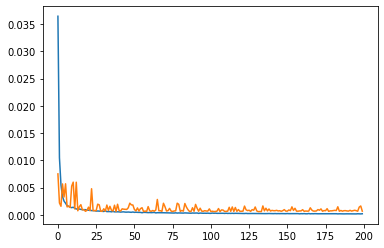

In [30]:
# Graph NN Error, mae and mse
plt.plot(ynnhistory.history['loss'])
plt.plot(ynnhistory.history['val_loss'])

**Yunzhou's Neural Net Model WITHOUT Mobility Data**

In [31]:
# Get data
X_YNN_nomob, y_YNN_nomob = get_YNN_states_dataset(state_cases_df, n_steps=N_STEPS)
X_train_YNN_nomob, X_test_YNN_nomob, y_train_YNN_nomob, y_test_YNN_nomob = train_test_split(X_YNN_nomob, y_YNN_nomob, test_size=SPLIT, shuffle=False)

# Set up model
n_ynn_features = X_train_YNN_nomob.shape[1]
ynn_nomob = build_YNN_model(n_ynn_features)

# Fit CNN
ynn_nomob_history = ynn_nomob.fit(X_train_YNN_nomob, y_train_YNN_nomob,
                                     epochs=EPOCHS,
                                     validation_data=(X_test_YNN_nomob, y_test_YNN_nomob),
                                     verbose=1,
                                     shuffle=False)

Train on 4222 samples, validate on 1056 samples
Epoch 1/200
4222/4222 [==============================] - 1s 137us/sample - loss: 0.0195 - mean_absolute_error: 0.0727 - mean_squared_error: 0.0195 - val_loss: 0.0121 - val_mean_absolute_error: 0.0612 - val_mean_squared_error: 0.0121
Epoch 2/200
4222/4222 [==============================] - 0s 54us/sample - loss: 0.0119 - mean_absolute_error: 0.0525 - mean_squared_error: 0.0119 - val_loss: 0.0104 - val_mean_absolute_error: 0.0559 - val_mean_squared_error: 0.0104
Epoch 3/200
4222/4222 [==============================] - 0s 51us/sample - loss: 0.0103 - mean_absolute_error: 0.0477 - mean_squared_error: 0.0103 - val_loss: 0.0079 - val_mean_absolute_error: 0.0476 - val_mean_squared_error: 0.0079
Epoch 4/200
4222/4222 [==============================] - 0s 43us/sample - loss: 0.0091 - mean_absolute_error: 0.0450 - mean_squared_error: 0.0091 - val_loss: 0.0065 - val_mean_absolute_error: 0.0432 - val_mean_squared_error: 0.0065
Epoch 5/200
4222/4222 [

Epoch 36/200
4222/4222 [==============================] - 0s 38us/sample - loss: 0.0030 - mean_absolute_error: 0.0244 - mean_squared_error: 0.0030 - val_loss: 0.0043 - val_mean_absolute_error: 0.0388 - val_mean_squared_error: 0.0043
Epoch 37/200
4222/4222 [==============================] - 0s 35us/sample - loss: 0.0030 - mean_absolute_error: 0.0247 - mean_squared_error: 0.0030 - val_loss: 0.0037 - val_mean_absolute_error: 0.0371 - val_mean_squared_error: 0.0037
Epoch 38/200
4222/4222 [==============================] - 0s 34us/sample - loss: 0.0031 - mean_absolute_error: 0.0246 - mean_squared_error: 0.0031 - val_loss: 0.0038 - val_mean_absolute_error: 0.0373 - val_mean_squared_error: 0.0038
Epoch 39/200
4222/4222 [==============================] - 0s 34us/sample - loss: 0.0030 - mean_absolute_error: 0.0240 - mean_squared_error: 0.0030 - val_loss: 0.0033 - val_mean_absolute_error: 0.0331 - val_mean_squared_error: 0.0033
Epoch 40/200
4222/4222 [==============================] - 0s 34us/sa

4222/4222 [==============================] - 0s 35us/sample - loss: 0.0025 - mean_absolute_error: 0.0221 - mean_squared_error: 0.0025 - val_loss: 0.0026 - val_mean_absolute_error: 0.0286 - val_mean_squared_error: 0.0026
Epoch 72/200
4222/4222 [==============================] - 0s 34us/sample - loss: 0.0024 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0024 - val_loss: 0.0027 - val_mean_absolute_error: 0.0321 - val_mean_squared_error: 0.0027
Epoch 73/200
4222/4222 [==============================] - 0s 35us/sample - loss: 0.0024 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0024 - val_loss: 0.0028 - val_mean_absolute_error: 0.0323 - val_mean_squared_error: 0.0028
Epoch 74/200
4222/4222 [==============================] - 0s 36us/sample - loss: 0.0024 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0024 - val_loss: 0.0022 - val_mean_absolute_error: 0.0265 - val_mean_squared_error: 0.0022
Epoch 75/200
4222/4222 [==============================] - 0s 36us/sample - loss: 

4222/4222 [==============================] - 0s 36us/sample - loss: 0.0021 - mean_absolute_error: 0.0209 - mean_squared_error: 0.0021 - val_loss: 0.0021 - val_mean_absolute_error: 0.0234 - val_mean_squared_error: 0.0021
Epoch 107/200
4222/4222 [==============================] - 0s 34us/sample - loss: 0.0019 - mean_absolute_error: 0.0205 - mean_squared_error: 0.0019 - val_loss: 0.0024 - val_mean_absolute_error: 0.0254 - val_mean_squared_error: 0.0024
Epoch 108/200
4222/4222 [==============================] - 0s 34us/sample - loss: 0.0021 - mean_absolute_error: 0.0208 - mean_squared_error: 0.0021 - val_loss: 0.0021 - val_mean_absolute_error: 0.0243 - val_mean_squared_error: 0.0021
Epoch 109/200
4222/4222 [==============================] - 0s 35us/sample - loss: 0.0019 - mean_absolute_error: 0.0192 - mean_squared_error: 0.0019 - val_loss: 0.0023 - val_mean_absolute_error: 0.0255 - val_mean_squared_error: 0.0023
Epoch 110/200
4222/4222 [==============================] - 0s 35us/sample - lo

4222/4222 [==============================] - 0s 40us/sample - loss: 0.0018 - mean_absolute_error: 0.0189 - mean_squared_error: 0.0018 - val_loss: 0.0035 - val_mean_absolute_error: 0.0296 - val_mean_squared_error: 0.0035
Epoch 142/200
4222/4222 [==============================] - 0s 39us/sample - loss: 0.0017 - mean_absolute_error: 0.0201 - mean_squared_error: 0.0017 - val_loss: 0.0026 - val_mean_absolute_error: 0.0296 - val_mean_squared_error: 0.0026
Epoch 143/200
4222/4222 [==============================] - 0s 38us/sample - loss: 0.0018 - mean_absolute_error: 0.0195 - mean_squared_error: 0.0018 - val_loss: 0.0029 - val_mean_absolute_error: 0.0286 - val_mean_squared_error: 0.0029
Epoch 144/200
4222/4222 [==============================] - 0s 36us/sample - loss: 0.0019 - mean_absolute_error: 0.0210 - mean_squared_error: 0.0019 - val_loss: 0.0024 - val_mean_absolute_error: 0.0285 - val_mean_squared_error: 0.0024
Epoch 145/200
4222/4222 [==============================] - 0s 54us/sample - lo

4222/4222 [==============================] - 0s 38us/sample - loss: 0.0017 - mean_absolute_error: 0.0193 - mean_squared_error: 0.0017 - val_loss: 0.0024 - val_mean_absolute_error: 0.0284 - val_mean_squared_error: 0.0024
Epoch 177/200
4222/4222 [==============================] - 0s 36us/sample - loss: 0.0019 - mean_absolute_error: 0.0195 - mean_squared_error: 0.0019 - val_loss: 0.0027 - val_mean_absolute_error: 0.0311 - val_mean_squared_error: 0.0027
Epoch 178/200
4222/4222 [==============================] - 0s 35us/sample - loss: 0.0018 - mean_absolute_error: 0.0200 - mean_squared_error: 0.0018 - val_loss: 0.0022 - val_mean_absolute_error: 0.0325 - val_mean_squared_error: 0.0022
Epoch 179/200
4222/4222 [==============================] - 0s 35us/sample - loss: 0.0016 - mean_absolute_error: 0.0191 - mean_squared_error: 0.0016 - val_loss: 0.0023 - val_mean_absolute_error: 0.0317 - val_mean_squared_error: 0.0023
Epoch 180/200
4222/4222 [==============================] - 0s 35us/sample - lo

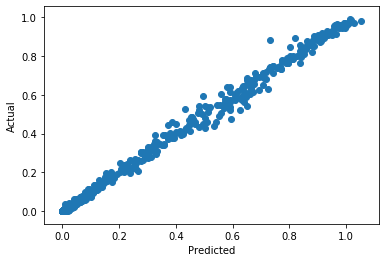

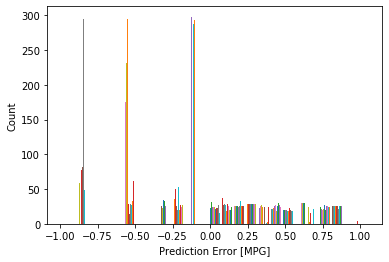

0.004527903903583825

In [51]:
# From the predicted vs. actual, we can see that the values are fitted pretty well
test_pred = ynn.predict(X_test_YNN)
plt.scatter(test_pred, y_test_YNN)
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.show()

# The errors seem to have much normality, but a bit right-skewed
errors = test_pred - y_test_YNN
plt.hist(errors, bins=25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")
plt.show()

# And the residuals mean is close to zero. 
np.mean(errors)

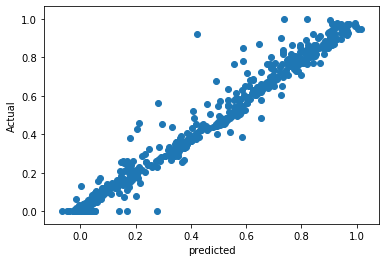

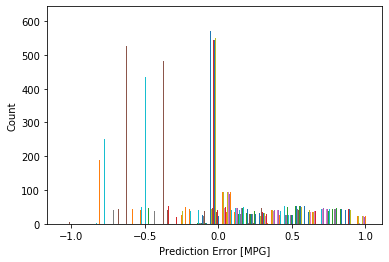

-0.007992969348711363

In [50]:
# Still, we can see that the predicted is pretty close to the actual, 
# but with less precisions as the model with Mobility data
test_ynn2 = ynn_nomob.predict(X_test_YNN_nomob)
plt.scatter(test_ynn2, y_test_YNN_nomob)
plt.xlabel("predicted")
plt.ylabel("Actual")
plt.show()

# Errors shows much normality, but seems to have a little right-skewed
errors2 = test_ynn2 - y_test_YNN_nomob
plt.hist(errors2, bins=25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")
plt.show()

# And the error mean is pretty closed to zero
np.mean(errors2)

In [44]:
models = ['lstm', 'lstm_nomob', 'slstm', 'slstm_nomob', 'cnn', 'cnn_nomob', 'ynn', 'ynn_nomob']

In [34]:
# lstm with X_test_LSTM and Y_test_LSTM
lstm_pred = lstm.predict(X_test_LSTM)
lstm_error = lstm_pred - y_test_LSTM

# lstm_nomob with X_test_LSTM_nomob and Y_test_LSTM_nomob
lstm_nomob_pred = lstm_nomob.predict(X_test_LSTM_nomob)
lstm_nomob_error = lstm_nomob_pred - y_test_LSTM_nomob

# slstm with X_test_LSTM and Y_test_LSTM
slstm_pred = slstm.predict(X_test_LSTM)
slstm_error = slstm_pred - y_test_LSTM

# slstm_nomob with X_test_LSTM_nomob and Y_test_LSTM_nomob
slstm_nomob_pred = slstm_nomob.predict(X_test_LSTM_nomob)
slstm_nomob_error = slstm_nomob_pred - y_test_LSTM_nomob

# cnn with X_test_CNN and Y_test_CNN
cnn_pred = cnn.predict(X_test_CNN)
cnn_error = cnn_pred - y_test_CNN

# cnn_nomob with X_test_CNN_nomob and Y_test_CNN_nomob
cnn_nomob_pred = cnn_nomob.predict(X_test_CNN_nomob)
cnn_nomob_error = cnn_nomob_pred - y_test_CNN_nomob

# ynn with X_test_YNN and Y_test_YNN
ynn_pred = ynn.predict(X_test_YNN)
ynn_error = ynn_pred - y_test_YNN

# ynn_nomob with X_test_YNN_nomob and Y_test_YNN_nomob
ynn_nomob_pred = ynn_nomob.predict(X_test_YNN_nomob)
ynn_nomob_error = ynn_nomob_pred - y_test_YNN_nomob

In [58]:
losses = []
maes = []
mses = []
loss, mae, mse = lstm.evaluate(X_test_LSTM, y_test_LSTM, verbose=0)
losses.append(loss)
maes.append(mae)
mses.append(mse)
print("LSTM: Testing set Mean Abs Error: {:5.5f}".format(mae))
print("--------")
loss, mae, mse = lstm_nomob.evaluate(X_test_LSTM_nomob, y_test_LSTM_nomob, verbose=0)
losses.append(loss)
maes.append(mae)
mses.append(mse)
print("LSTM without mobility: Testing set Mean Abs Error: {:5.5f}".format(mae))
print("--------")
loss, mae, mse = slstm.evaluate(X_test_LSTM, y_test_LSTM, verbose=0)
losses.append(loss)
maes.append(mae)
mses.append(mse)
print("Stacked LSTM: Testing set Mean Abs Error: {:5.5f}".format(mae))
print("--------")
loss, mae, mse = slstm_nomob.evaluate(X_test_LSTM_nomob, y_test_LSTM_nomob, verbose=0)
losses.append(loss)
maes.append(mae)
mses.append(mse)
print("Stacked LSTM without mobility: Testing set Mean Abs Error: {:5.5f}".format(mae))
print("--------")
loss, mae, mse = cnn.evaluate(X_test_CNN, y_test_CNN, verbose=0)
losses.append(loss)
maes.append(mae)
mses.append(mse)
print("CNN: Testing set Mean Abs Error: {:5.5f}".format(mae))
print("--------")
loss, mae, mse = cnn_nomob.evaluate(X_test_CNN_nomob, y_test_CNN_nomob, verbose=0)
losses.append(loss)
maes.append(mae)
mses.append(mse)
print("CNN without mobility: Testing set Mean Abs Error: {:5.5f}".format(mae))
print("--------")
loss, mae, mse = ynn.evaluate(X_test_YNN, y_test_YNN, verbose=0)
losses.append(loss)
maes.append(mae)
mses.append(mse)
print("NN: Testing set Mean Abs Error: {:5.5f}".format(mae))
print("--------")
loss, mae, mse = ynn_nomob.evaluate(X_test_YNN_nomob, y_test_YNN_nomob, verbose=0)
losses.append(loss)
maes.append(mae)
mses.append(mse)
print("NN without mobility: Testing set Mean Abs Error: {:5.5f}".format(mae))

LSTM: Testing set Mean Abs Error: 0.00788
--------
LSTM without mobility: Testing set Mean Abs Error: 0.01892
--------
Stacked LSTM: Testing set Mean Abs Error: 0.00812
--------
Stacked LSTM without mobility: Testing set Mean Abs Error: 0.01837
--------
CNN: Testing set Mean Abs Error: 0.01617
--------
CNN without mobility: Testing set Mean Abs Error: 0.03479
--------
NN: Testing set Mean Abs Error: 0.01556
--------
NN without mobility: Testing set Mean Abs Error: 0.03068


In [59]:
print("models, losses, maes, mses")
for i in range(len(models)):
    print(models[i], ":", "{:5.5f}".format(losses[i]), "{:5.5f}".format(maes[i]), "{:5.5f}".format(mses[i]))

models, losses, maes, mses
lstm : 0.00021 0.00788 0.00021
lstm_nomob : 0.00210 0.01892 0.00210
slstm : 0.00022 0.00812 0.00022
slstm_nomob : 0.00201 0.01837 0.00201
cnn : 0.00072 0.01617 0.00072
cnn_nomob : 0.00579 0.03479 0.00579
ynn : 0.00066 0.01556 0.00066
ynn_nomob : 0.00234 0.03068 0.00234
